# CNN实现跌倒检测

In [1]:
import os
import torch
from torch.utils import data
from PIL import Image
import numpy as np
from torchvision import transforms,datasets
import shutil
from torch.nn import init
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time 

### 导入数据集

In [9]:
transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])  ])

In [10]:
train_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/dataset/dataset/train',transform=transform)
val_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/dataset/dataset/val',transform=transform)
test_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/dataset/dataset/test',transform=transform)

In [11]:
batch_size=100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

### 定义模型

In [12]:
class MyConvModule(torch.nn.Module):
    def __init__(self):
        super(MyConvModule,self).__init__()
        self.conv1=torch.nn.Sequential(torch.nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5),
                                     torch.nn.BatchNorm2d(6),
                                     torch.nn.ReLU(inplace=True))
        self.maxpool=torch.nn.MaxPool2d(2, 2)
        self.conv2=torch.nn.Sequential(torch.nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5),
                                     torch.nn.BatchNorm2d(16),
                                     torch.nn.ReLU(inplace=True))
        self.fc1=torch.nn.Linear(16*53*53,1024)
        self.fc2=torch.nn.Linear(1024,512)
        self.fc3=torch.nn.Linear(512,3)
        
    def forward(self,X):
        X=self.conv1(X)
        X=self.maxpool(X)
        X=self.conv2(X)
        X=self.maxpool(X)
        X=X.view(-1,16*53*53)
        X=F.relu(self.fc1(X))
        X=F.relu(self.fc2(X))
        X=self.fc3(X)
        return X

### 定义训练模型函数

In [24]:
def train(net,data_loader):
    net.train()
    train_batch_num=len(data_loader)
    total_loss=0
    correct=0
    sample_num=0
    for batch_idx,(data,target) in enumerate(data_loader):
        optimizer.zero_grad()
        output=net(data)
        loss=criterion(output,target)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        prediction=torch.argmax(output,1)
        correct+=(prediction==target).sum().item()
        sample_num+=len(prediction)
    loss=total_loss/train_batch_num
    acc=correct/sample_num
    return loss,acc

### 定义测试模型函数

In [25]:
def test(net,data_loader):
    net.eval()
    test_batch_num=len(data_loader)
    total_loss=0
    correct=0
    sample_num=0
    for batch_idx,(data,target) in enumerate(data_loader):
        output=net(data)
        loss=criterion(output,target)
        total_loss+=loss.item()
        prediction=torch.argmax(output,1)
        correct+=(prediction==target).sum().item()
        sample_num+=len(prediction)
    loss=total_loss/test_batch_num
    acc=correct/sample_num
    return loss,acc

### 定义损失函数与优化器

In [26]:
net=MyConvModule()
print(net)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)
criterion=torch.nn.CrossEntropyLoss()

MyConvModule(
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc1): Linear(in_features=44944, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=3, bias=True)
)


### 进行迭代

In [27]:
epoch=10
train_loss_list=[]
train_acc_list=[]
val_loss_list=[]
val_acc_list=[]
test_loss_list=[]
test_acc_list=[]
since=time.time()
for epoch in range(epoch):
    train_loss,train_acc=train(net,train_loader)
    val_loss,val_acc=test(net,val_loader)
    test_loss,test_acc=test(net,test_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print(f"epoch: {epoch} \t train_loss: {train_loss:.4f}\t"
          f" train_acc: {train_acc}\t"
          f" val_loss: {val_loss:.4f}\t val_acc:{val_acc}"
          f" test_loss: {test_loss:.4f}\t test_acc:{test_acc}")
time_elapsed=(time.time()-since)/60

epoch: 0 	 train_loss: 0.6295	 train_acc: 0.7901498929336188	 val_loss: 0.7586	 val_acc:0.7912087912087912 test_loss: 0.8331	 test_acc:0.6689895470383276
epoch: 1 	 train_loss: 0.2185	 train_acc: 0.9379014989293362	 val_loss: 0.5320	 val_acc:0.7912087912087912 test_loss: 0.7188	 test_acc:0.6689895470383276
epoch: 2 	 train_loss: 0.1230	 train_acc: 0.9571734475374732	 val_loss: 0.5945	 val_acc:0.7912087912087912 test_loss: 0.8588	 test_acc:0.6689895470383276
epoch: 3 	 train_loss: 0.0825	 train_acc: 0.9775160599571735	 val_loss: 0.4545	 val_acc:0.8178963893249608 test_loss: 0.6227	 test_acc:0.6376306620209059
epoch: 4 	 train_loss: 0.0619	 train_acc: 0.9796573875802997	 val_loss: 0.5306	 val_acc:0.7864992150706437 test_loss: 0.6662	 test_acc:0.6480836236933798
epoch: 5 	 train_loss: 0.0596	 train_acc: 0.9807280513918629	 val_loss: 0.5491	 val_acc:0.7660910518053375 test_loss: 0.6393	 test_acc:0.7526132404181185
epoch: 6 	 train_loss: 0.0502	 train_acc: 0.9828693790149893	 val_loss: 0.60

### 计算迭代时间

In [31]:
time_elapsed

3.182254195213318

### 绘制训练集与测试集的loss曲线与精度曲线

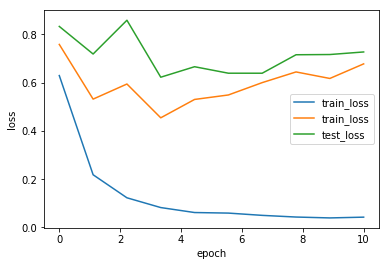

In [32]:
x=np.linspace(0,len(train_loss_list),len(test_loss_list))
plt.plot(x,train_loss_list,label="train_loss",linewidth=1.5)
plt.plot(x,val_loss_list,label="val_loss",linewidth=1.5)
plt.plot(x,test_loss_list,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

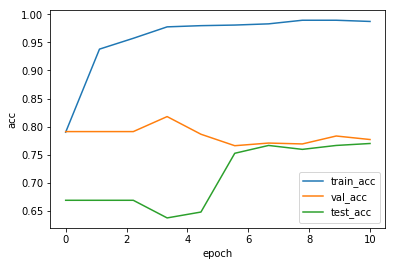

In [33]:
x=np.linspace(0,len(train_acc_list),len(test_acc_list))
plt.plot(x,train_acc_list,label="train_acc",linewidth=1.5)
plt.plot(x,val_acc_list,label="val_acc",linewidth=1.5)
plt.plot(x,test_acc_list,label="test_acc",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

## 不同超参数对比
### 改变卷积层数（一层）

In [50]:
transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])  ])

In [51]:
train_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/dataset/dataset/train',transform=transform)
val_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/dataset/dataset/val',transform=transform)
test_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/dataset/dataset/test',transform=transform)

In [52]:
batch_size=100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [53]:
class MyConvModule(torch.nn.Module):
    def __init__(self):
        super(MyConvModule,self).__init__()
        self.conv1=torch.nn.Sequential(torch.nn.Conv2d(in_channels=3,out_channels=32,kernel_size=11),
                                     torch.nn.BatchNorm2d(32),
                                     torch.nn.ReLU(inplace=True))
        self.maxpool=torch.nn.MaxPool2d(10, 4)
        self.fc1=torch.nn.Linear(32*52*52,1024)
        self.fc2=torch.nn.Linear(1024,512)
        self.fc3=torch.nn.Linear(512,3)
        
    def forward(self,X):
        X=self.conv1(X)
        X=self.maxpool(X)
        X=X.view(-1,32*52*52)
        X=F.relu(self.fc1(X))
        X=F.relu(self.fc2(X))
        X=self.fc3(X)
        return X

In [54]:
def train(net,data_loader):
    net.train()
    train_batch_num=len(data_loader)
    total_loss=0
    correct=0
    sample_num=0
    for batch_idx,(data,target) in enumerate(data_loader):
        optimizer.zero_grad()
        output=net(data)
        loss=criterion(output,target)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        prediction=torch.argmax(output,1)
        correct+=(prediction==target).sum().item()
        sample_num+=len(prediction)
    loss=total_loss/train_batch_num
    acc=correct/sample_num
    return loss,acc

In [55]:
def test(net,data_loader):
    net.eval()
    test_batch_num=len(data_loader)
    total_loss=0
    correct=0
    sample_num=0
    for batch_idx,(data,target) in enumerate(data_loader):
        output=net(data)
        loss=criterion(output,target)
        total_loss+=loss.item()
        prediction=torch.argmax(output,1)
        correct+=(prediction==target).sum().item()
        sample_num+=len(prediction)
    loss=total_loss/test_batch_num
    acc=correct/sample_num
    return loss,acc

In [56]:
net=MyConvModule()
print(net)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)
criterion=torch.nn.CrossEntropyLoss()

MyConvModule(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=10, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=86528, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=3, bias=True)
)


In [57]:
epoch=10
train_loss_list=[]
train_acc_list=[]
val_loss_list=[]
val_acc_list=[]
test_loss_list=[]
test_acc_list=[]
since=time.time()
for epoch in range(epoch):
    train_loss,train_acc=train(net,train_loader)
    val_loss,val_acc=test(net,val_loader)
    test_loss,test_acc=test(net,test_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print(f"epoch: {epoch} \t train_loss: {train_loss:.4f}\t"
          f" train_acc: {train_acc}\t"
          f" val_loss: {val_loss:.4f}\t val_acc:{val_acc}"
          f" test_loss: {test_loss:.4f}\t test_acc:{test_acc}")
time_elapsed=(time.time()-since)/60

epoch: 0 	 train_loss: 0.4753	 train_acc: 0.7922912205567452	 val_loss: 0.5473	 val_acc:0.7912087912087912 test_loss: 0.7551	 test_acc:0.6689895470383276
epoch: 1 	 train_loss: 0.1530	 train_acc: 0.9400428265524625	 val_loss: 0.5168	 val_acc:0.7786499215070644 test_loss: 0.6158	 test_acc:0.6236933797909407
epoch: 2 	 train_loss: 0.0946	 train_acc: 0.9732334047109208	 val_loss: 0.5640	 val_acc:0.7817896389324961 test_loss: 0.5954	 test_acc:0.6724738675958188
epoch: 3 	 train_loss: 0.0590	 train_acc: 0.9796573875802997	 val_loss: 0.6924	 val_acc:0.7802197802197802 test_loss: 0.6377	 test_acc:0.735191637630662
epoch: 4 	 train_loss: 0.0620	 train_acc: 0.9764453961456103	 val_loss: 0.7435	 val_acc:0.7629513343799058 test_loss: 0.7603	 test_acc:0.7456445993031359
epoch: 5 	 train_loss: 0.0599	 train_acc: 0.9796573875802997	 val_loss: 0.8182	 val_acc:0.728414442700157 test_loss: 0.8664	 test_acc:0.7630662020905923
epoch: 6 	 train_loss: 0.0519	 train_acc: 0.9807280513918629	 val_loss: 0.8862

In [58]:
time_elapsed

6.565139667193095

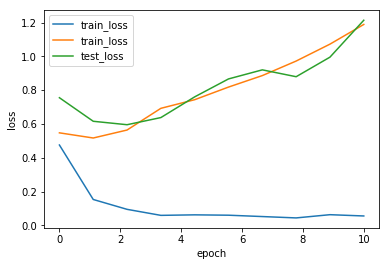

In [59]:
x=np.linspace(0,len(train_loss_list),len(test_loss_list))
plt.plot(x,train_loss_list,label="train_loss",linewidth=1.5)
plt.plot(x,val_loss_list,label="val_loss",linewidth=1.5)
plt.plot(x,test_loss_list,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

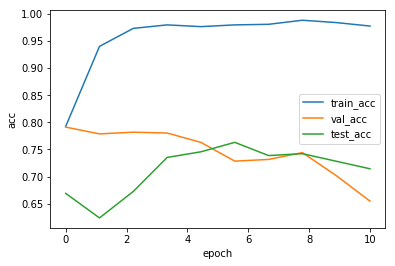

In [60]:
x=np.linspace(0,len(train_acc_list),len(test_acc_list))
plt.plot(x,train_acc_list,label="train_acc",linewidth=1.5)
plt.plot(x,val_acc_list,label="val_acc",linewidth=1.5)
plt.plot(x,test_acc_list,label="test_acc",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

## 不同超参数对比
### 改变学习率 1e-4

In [61]:
transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])  ])

In [62]:
train_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/dataset/dataset/train',transform=transform)
val_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/dataset/dataset/val',transform=transform)
test_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/dataset/dataset/test',transform=transform)

In [63]:
batch_size=100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [64]:
class MyConvModule(torch.nn.Module):
    def __init__(self):
        super(MyConvModule,self).__init__()
        self.conv1=torch.nn.Sequential(torch.nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5),
                                     torch.nn.BatchNorm2d(6),
                                     torch.nn.ReLU(inplace=True))
        self.maxpool=torch.nn.MaxPool2d(2, 2)
        self.conv2=torch.nn.Sequential(torch.nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5),
                                     torch.nn.BatchNorm2d(16),
                                     torch.nn.ReLU(inplace=True))
        self.fc1=torch.nn.Linear(16*53*53,1024)
        self.fc2=torch.nn.Linear(1024,512)
        self.fc3=torch.nn.Linear(512,3)
        
    def forward(self,X):
        X=self.conv1(X)
        X=self.maxpool(X)
        X=self.conv2(X)
        X=self.maxpool(X)
        X=X.view(-1,16*53*53)
        X=F.relu(self.fc1(X))
        X=F.relu(self.fc2(X))
        X=self.fc3(X)
        return X

In [65]:
def train(net,data_loader):
    net.train()
    train_batch_num=len(data_loader)
    total_loss=0
    correct=0
    sample_num=0
    for batch_idx,(data,target) in enumerate(data_loader):
        optimizer.zero_grad()
        output=net(data)
        loss=criterion(output,target)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        prediction=torch.argmax(output,1)
        correct+=(prediction==target).sum().item()
        sample_num+=len(prediction)
    loss=total_loss/train_batch_num
    acc=correct/sample_num
    return loss,acc

In [66]:
def test(net,data_loader):
    net.eval()
    test_batch_num=len(data_loader)
    total_loss=0
    correct=0
    sample_num=0
    for batch_idx,(data,target) in enumerate(data_loader):
        output=net(data)
        loss=criterion(output,target)
        total_loss+=loss.item()
        prediction=torch.argmax(output,1)
        correct+=(prediction==target).sum().item()
        sample_num+=len(prediction)
    loss=total_loss/test_batch_num
    acc=correct/sample_num
    return loss,acc

In [67]:
net=MyConvModule()
print(net)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
criterion=torch.nn.CrossEntropyLoss()

MyConvModule(
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc1): Linear(in_features=44944, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=3, bias=True)
)


In [68]:
epoch=10
train_loss_list=[]
train_acc_list=[]
val_loss_list=[]
val_acc_list=[]
test_loss_list=[]
test_acc_list=[]
since=time.time()
for epoch in range(epoch):
    train_loss,train_acc=train(net,train_loader)
    val_loss,val_acc=test(net,val_loader)
    test_loss,test_acc=test(net,test_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print(f"epoch: {epoch} \t train_loss: {train_loss:.4f}\t"
          f" train_acc: {train_acc}\t"
          f" val_loss: {val_loss:.4f}\t val_acc:{val_acc}"
          f" test_loss: {test_loss:.4f}\t test_acc:{test_acc}")
time_elapsed=(time.time()-since)/60

epoch: 0 	 train_loss: 0.3235	 train_acc: 0.8394004282655246	 val_loss: 0.4792	 val_acc:0.7912087912087912 test_loss: 0.6163	 test_acc:0.6689895470383276
epoch: 1 	 train_loss: 0.0802	 train_acc: 0.9657387580299786	 val_loss: 0.9798	 val_acc:0.7912087912087912 test_loss: 1.4046	 test_acc:0.6689895470383276
epoch: 2 	 train_loss: 0.0423	 train_acc: 0.9807280513918629	 val_loss: 0.9179	 val_acc:0.8210361067503925 test_loss: 1.0837	 test_acc:0.7003484320557491
epoch: 3 	 train_loss: 0.0355	 train_acc: 0.9860813704496788	 val_loss: 0.5533	 val_acc:0.8351648351648352 test_loss: 0.4858	 test_acc:0.8327526132404182
epoch: 4 	 train_loss: 0.0240	 train_acc: 0.9903640256959315	 val_loss: 0.6685	 val_acc:0.8021978021978022 test_loss: 0.5602	 test_acc:0.8222996515679443
epoch: 5 	 train_loss: 0.0499	 train_acc: 0.9839400428265525	 val_loss: 1.5058	 val_acc:0.6797488226059655 test_loss: 1.2497	 test_acc:0.8083623693379791
epoch: 6 	 train_loss: 0.0877	 train_acc: 0.9668094218415417	 val_loss: 1.52

In [69]:
time_elapsed

2.929544138908386

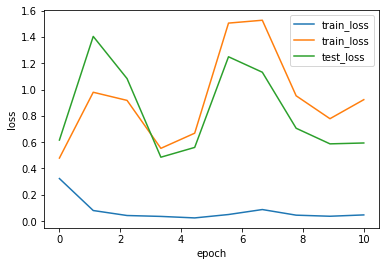

In [70]:
x=np.linspace(0,len(train_loss_list),len(test_loss_list))
plt.plot(x,train_loss_list,label="train_loss",linewidth=1.5)
plt.plot(x,val_loss_list,label="val_loss",linewidth=1.5)
plt.plot(x,test_loss_list,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

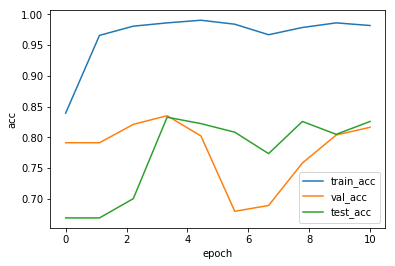

In [71]:
x=np.linspace(0,len(train_acc_list),len(test_acc_list))
plt.plot(x,train_acc_list,label="train_acc",linewidth=1.5)
plt.plot(x,val_acc_list,label="val_acc",linewidth=1.5)
plt.plot(x,test_acc_list,label="test_acc",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

## 不同超参数对比
### 改变学习率 1e-2

In [72]:
transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])  ])

In [73]:
train_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/dataset/dataset/train',transform=transform)
val_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/dataset/dataset/val',transform=transform)
test_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/dataset/dataset/test',transform=transform)

In [74]:
batch_size=100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [75]:
class MyConvModule(torch.nn.Module):
    def __init__(self):
        super(MyConvModule,self).__init__()
        self.conv1=torch.nn.Sequential(torch.nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5),
                                     torch.nn.BatchNorm2d(6),
                                     torch.nn.ReLU(inplace=True))
        self.maxpool=torch.nn.MaxPool2d(2, 2)
        self.conv2=torch.nn.Sequential(torch.nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5),
                                     torch.nn.BatchNorm2d(16),
                                     torch.nn.ReLU(inplace=True))
        self.fc1=torch.nn.Linear(16*53*53,1024)
        self.fc2=torch.nn.Linear(1024,512)
        self.fc3=torch.nn.Linear(512,3)
        
    def forward(self,X):
        X=self.conv1(X)
        X=self.maxpool(X)
        X=self.conv2(X)
        X=self.maxpool(X)
        X=X.view(-1,16*53*53)
        X=F.relu(self.fc1(X))
        X=F.relu(self.fc2(X))
        X=self.fc3(X)
        return X

In [76]:
def train(net,data_loader):
    net.train()
    train_batch_num=len(data_loader)
    total_loss=0
    correct=0
    sample_num=0
    for batch_idx,(data,target) in enumerate(data_loader):
        optimizer.zero_grad()
        output=net(data)
        loss=criterion(output,target)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        prediction=torch.argmax(output,1)
        correct+=(prediction==target).sum().item()
        sample_num+=len(prediction)
    loss=total_loss/train_batch_num
    acc=correct/sample_num
    return loss,acc

In [77]:
def test(net,data_loader):
    net.eval()
    test_batch_num=len(data_loader)
    total_loss=0
    correct=0
    sample_num=0
    for batch_idx,(data,target) in enumerate(data_loader):
        output=net(data)
        loss=criterion(output,target)
        total_loss+=loss.item()
        prediction=torch.argmax(output,1)
        correct+=(prediction==target).sum().item()
        sample_num+=len(prediction)
    loss=total_loss/test_batch_num
    acc=correct/sample_num
    return loss,acc

In [78]:
net=MyConvModule()
print(net)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
criterion=torch.nn.CrossEntropyLoss()

MyConvModule(
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc1): Linear(in_features=44944, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=3, bias=True)
)


In [79]:
epoch=10
train_loss_list=[]
train_acc_list=[]
val_loss_list=[]
val_acc_list=[]
test_loss_list=[]
test_acc_list=[]
since=time.time()
for epoch in range(epoch):
    train_loss,train_acc=train(net,train_loader)
    val_loss,val_acc=test(net,val_loader)
    test_loss,test_acc=test(net,test_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print(f"epoch: {epoch} \t train_loss: {train_loss:.4f}\t"
          f" train_acc: {train_acc}\t"
          f" val_loss: {val_loss:.4f}\t val_acc:{val_acc}"
          f" test_loss: {test_loss:.4f}\t test_acc:{test_acc}")
time_elapsed=(time.time()-since)/60

epoch: 0 	 train_loss: 211.2763	 train_acc: 0.5642398286937902	 val_loss: 3.8338	 val_acc:0.5745682888540031 test_loss: 6.2746	 test_acc:0.7073170731707317
epoch: 1 	 train_loss: 1.3206	 train_acc: 0.892933618843683	 val_loss: 28.3520	 val_acc:0.39717425431711145 test_loss: 31.9339	 test_acc:0.6097560975609756
epoch: 2 	 train_loss: 0.4915	 train_acc: 0.8458244111349036	 val_loss: 2.8277	 val_acc:0.5886970172684458 test_loss: 5.5608	 test_acc:0.662020905923345
epoch: 3 	 train_loss: 0.1834	 train_acc: 0.9400428265524625	 val_loss: 1.2259	 val_acc:0.6875981161695447 test_loss: 1.5414	 test_acc:0.7909407665505227
epoch: 4 	 train_loss: 0.1293	 train_acc: 0.9486081370449678	 val_loss: 2.0867	 val_acc:0.7708006279434851 test_loss: 3.8250	 test_acc:0.7979094076655052
epoch: 5 	 train_loss: 0.1397	 train_acc: 0.9475374732334048	 val_loss: 1.2898	 val_acc:0.7582417582417582 test_loss: 2.5151	 test_acc:0.7979094076655052
epoch: 6 	 train_loss: 0.1658	 train_acc: 0.9207708779443254	 val_loss: 1

In [83]:
time_elapsed

3.8906431198120117

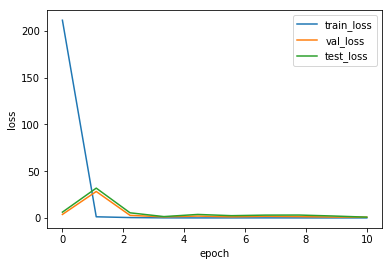

In [84]:
x=np.linspace(0,len(train_loss_list),len(test_loss_list))
plt.plot(x,train_loss_list,label="train_loss",linewidth=1.5)
plt.plot(x,val_loss_list,label="val_loss",linewidth=1.5)
plt.plot(x,test_loss_list,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

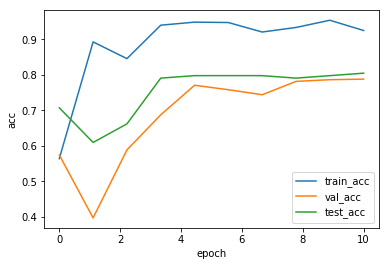

In [85]:
x=np.linspace(0,len(train_acc_list),len(test_acc_list))
plt.plot(x,train_acc_list,label="train_acc",linewidth=1.5)
plt.plot(x,val_acc_list,label="val_acc",linewidth=1.5)
plt.plot(x,test_acc_list,label="test_acc",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()